In [23]:
import sys
from itertools import product
from os import listdir
import numpy as np
import scipy.sparse as sparse
import json

# Pull genotypes for a chromosome
famkey = 'AU3702'
lcl_id = 'AU3702307_LCL'
wb_id = 'AU3702307'
data_dir = '../split_gen_ihart'

param_file = '%s_params.json' % famkey
sample_file = '%s/chr.1.gen.samples.txt' % (data_dir)

chroms = [str(x) for x in range(1, 23)] + ['X', 'Y']

In [4]:
# pull families with sequence data
with open(sample_file, 'r') as f:
    sample_id_to_index = dict([(line.strip(), i) for i, line in enumerate(f)])

lcl_index, wb_index = sample_id_to_index[lcl_id], sample_id_to_index[wb_id]

In [20]:
chrom_lengths = {
	'1': 225934550,
	'2': 238204522,
	'3': 194797140,
	'4': 188042934,
	'5': 177695260,
	'6': 167395067,
	'7': 155536559,
	'8': 142964911,
	'9': 120626573,
	'10': 131314747,
	'11': 131169619,
	'12': 130481395,
	'13': 95589878,
	'14': 88289540,
	'15': 81694769,
	'16': 78884753,
	'17': 78129607,
	'18': 74661510,
	'19': 56060841,
	'20': 59505520,
	'21': 35134224,
	'22': 34894566,
	'X': 151100560,
	'Y': 25653566
}

# Compare error rates


In [46]:
indices = [lcl_index, wb_index]
all_gens = [None for _ in chroms]
all_positions = [None for _ in chroms]
num_calls = [None for _ in chroms]
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    try:
        gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

        # pull snp positions
        pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
        snp_positions = pos_data[:, 1]
        is_snp = pos_data[:, 2].astype(bool)

        # Pull data together
        A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[indices, :] for gen_file in gen_files])

        # filter out snps
        A = A[:, is_snp].A
        snp_positions = snp_positions[is_snp]
        num_calls[i] = snp_positions.shape[0]

        # don't need low coverage flag on missing values
        A[A<0] = -1

        print(A.shape)
        all_gens[i] = A
        all_positions[i] = snp_positions
    except Exception as e:
        print('Error')
        print(e)

1 (2, 5734832)
2 (2, 6130682)
3 (2, 5004468)
4 (2, 5057877)
5 (2, 4605420)
6 (2, 4331684)
7 (2, 4190321)
8 (2, 3992696)
9 (2, 3305436)
10 (2, 3463889)
11 (2, 3473317)
12 (2, 3317019)
13 (2, 2475224)
14 (2, 2344178)
15 (2, 2164322)
16 (2, 2420607)
17 (2, 2023375)
18 (2, 1951594)
19 (2, 1625347)
20 (2, 1567602)
21 (2, 1055547)
22 (2, 1004649)
X (2, 2965581)
Y (2, 231075)


In [6]:
chrom = '4'
i = 3

gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f])

# pull snp positions
pos_data = np.load('%s/chr.%s.gen.coordinates.npy' % (data_dir, chrom))
snp_positions = pos_data[:, 1]
is_snp = pos_data[:, 2].astype(bool)

# Pull data together
A = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[indices, :] for gen_file in gen_files])
        
# filter out snps
A = A[:, is_snp].A
snp_positions = snp_positions[is_snp]
num_calls[i] = snp_positions.shape[0]

# don't need low coverage flag on missing values
A[A<0] = -1

print(A.shape)
all_gens[i] = A
all_positions[i] = snp_positions

(2, 278530)


In [32]:
# chrom, lcl (0, 1, 2, -1), wb (0, 1, 2, -1)
counts = np.zeros((len(chroms), 4, 4))
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    gs, cs = np.unique(all_gens[i], axis=1, return_counts=True)
    for gen, count in zip(gs.T, cs.T):
        counts[i, gen[0], gen[1]] = count
    counts[i, 0, 0] = chrom_lengths[chrom] - np.sum(counts[i, :, :])
print(counts[0])

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 X Y [[2.25594045e+08 7.27900000e+03 6.10000000e+01 9.39800000e+03]
 [6.75300000e+03 1.89674000e+05 4.02000000e+02 4.02000000e+02]
 [5.30000000e+01 3.57000000e+02 1.04480000e+05 3.99000000e+02]
 [6.26500000e+03 1.87000000e+02 3.68000000e+02 1.44270000e+04]]


In [33]:
# obs, true
error_rate = np.zeros((4, 6))
with open(param_file, 'r') as f:
    params = json.load(f)

for i, obs in enumerate(['0/0', '0/1', '1/1', './.']):
    for j, true_gen in enumerate(['0/0', '0/1', '1/1', '-/0', '-/1', '-/-']):
        error_rate[i, j] = np.power(10.0, -params["-log10(P[obs=%s|true_gen=%s])" % (obs, true_gen)])
print(error_rate)

[[9.98949563e-01 7.71608472e-03 2.26819669e-05 9.97584318e-01
  3.84917882e-05 3.85445141e-02]
 [4.07205020e-04 9.90027132e-01 6.39089941e-04 8.47573951e-04
  8.57735391e-03 3.71904073e-04]
 [4.86238045e-06 1.13453203e-03 9.98586574e-01 1.13894827e-05
  9.89520733e-01 3.63110746e-03]
 [6.38369861e-04 1.12225093e-03 7.51653970e-04 1.55671834e-03
  1.86342178e-03 9.57452474e-01]]


In [43]:
#lcl, wb
error_types = [(a, b) for a, b in product([0, 1, 2], repeat=2) if a!=b]
print(error_types)
    
# chrom, lcl, wb
exp = np.zeros((len(chroms), 4, 4))
for i, chrom in enumerate(chroms):
    if chrom != 'X' and chrom != 'Y':
        for lcl_gen, wb_gen in error_types:
            # first, let's say LCL is correct, and the WB is the error
            exp[i, lcl_gen, wb_gen] = counts[i, lcl_gen, lcl_gen]*error_rate[wb_gen, lcl_gen]
            exp[i, lcl_gen, wb_gen] += counts[i, wb_gen, wb_gen]*error_rate[lcl_gen, wb_gen]

            
            

[(0, 1), (0, 2), (1, 0), (1, 2), (2, 0), (2, 1)]


In [44]:
print(counts.shape, exp.shape)

(24, 4, 4) (24, 4, 4)


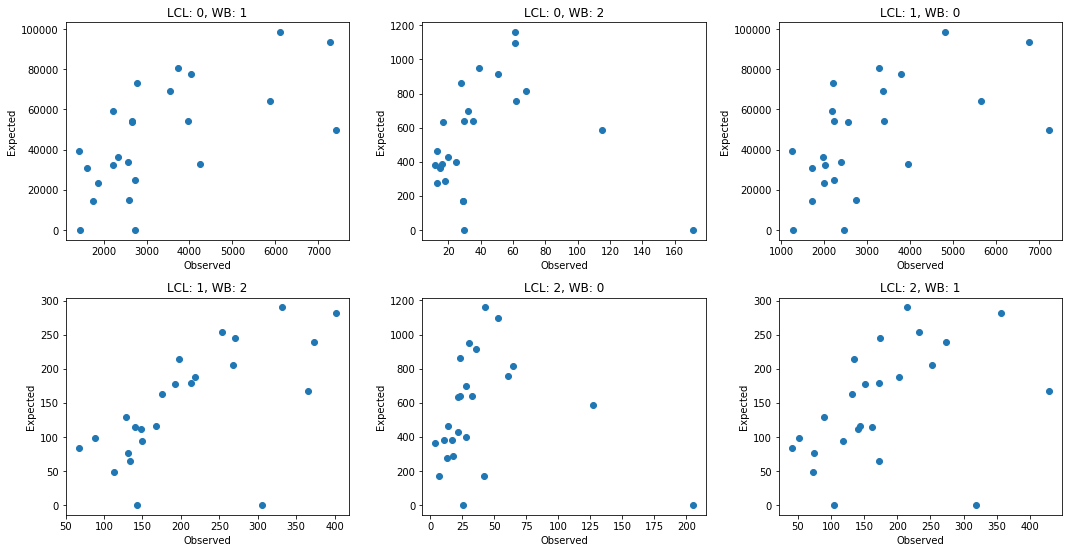

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

for i, (lcl_gen, wb_gen) in enumerate(error_types):
    plt.subplot(4, 3, i+1)
    plt.scatter(counts[:, lcl_gen, wb_gen], exp[:, lcl_gen, wb_gen])
    plt.xlabel('Observed')
    plt.ylabel('Expected')
    plt.title('LCL: %d, WB: %d' % (lcl_gen, wb_gen))
    
plt.tight_layout()
plt.show()